In [1]:
from nilmtk.api import API
import warnings
warnings.filterwarnings("ignore")
from nilmtk.disaggregate import SGN
from nilmtk.disaggregate import DM

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

# from src import *

USE_GPU = True
device = torch.device("cuda:0" if USE_GPU and torch.cuda.is_available() else "cpu")
print(torch.__version__, pl.__version__, device)

2.0.1 2.0.4 cuda:0


DM
Started training for  DM
Joint training for  DM
............... Loading Data for training ...................
Loading data for  ukdale  dataset
Loading building ...  1
Dropping missing values
Train Jointly
Doing Preprocessing
Train main (3601, 480)
Train main 2 (3601, 480, 1)
First model training for fridge
Is Time embed used ?  True
Use cuda True
Main shape (3601, 480, 1)
App shape (3601, 480, 1)
Epoch: 0, Valid_Loss: 0.28534212708473206, Time consumption: 11.631551742553711s.
Epoch: 1, Valid_Loss: 0.20973776280879974, Time consumption: 8.814063787460327s.
Epoch: 2, Valid_Loss: 0.16065914928913116, Time consumption: 8.793038845062256s.
Epoch: 3, Valid_Loss: 0.11875033378601074, Time consumption: 9.169070959091187s.
Epoch: 4, Valid_Loss: 0.09122008830308914, Time consumption: 8.782843112945557s.
Epoch: 5, Valid_Loss: 0.08456059545278549, Time consumption: 8.606852769851685s.
Epoch: 6, Valid_Loss: 0.07256267219781876, Time consumption: 8.680678844451904s.
Epoch: 7, Valid_Loss: 0.0671

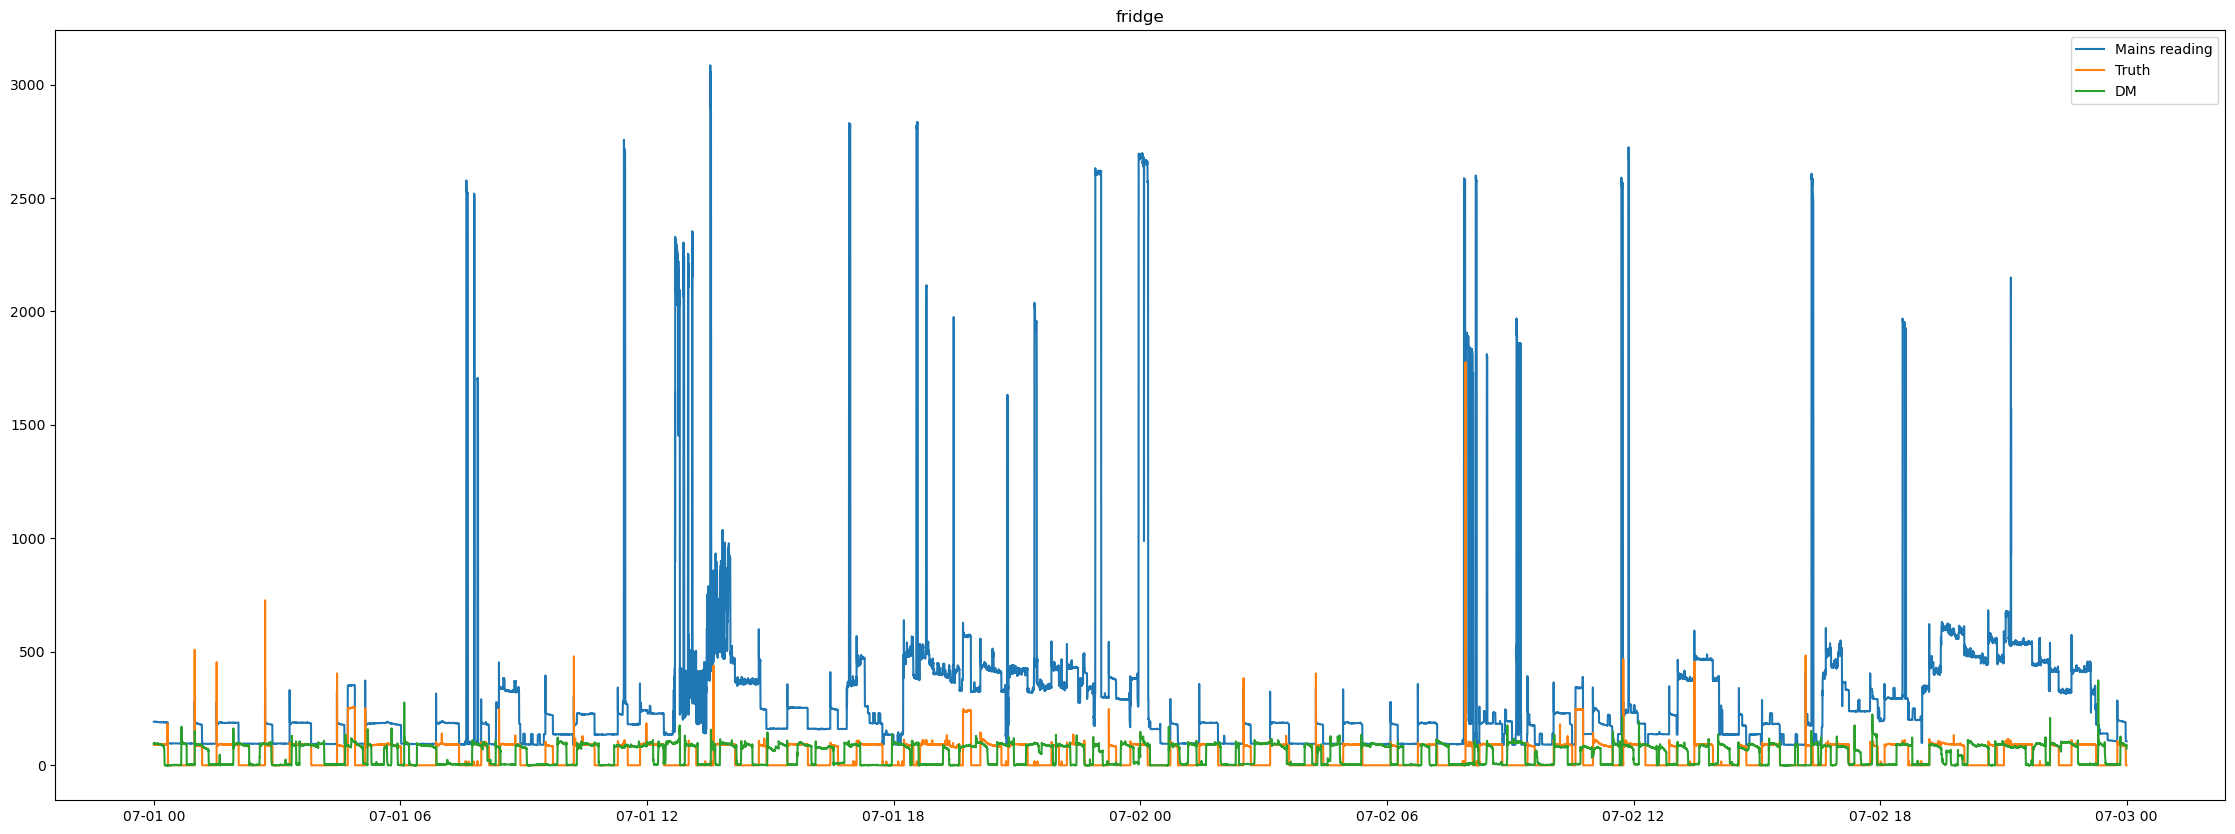

In [3]:
e = {
  # Specify power type, sample rate and disaggregated appliance
  'power': {
    'mains': ['active'],
    'appliance': ['active']
  },
  'sample_rate': 6,
  'appliances': ['fridge'],
  # Universally no pre-training
  'pre_trained':False,
  # Specify algorithm hyper-parameters
  'methods':{"DM":DM({'n_epochs':40,'batch_size':32,'sequence_length':480, 'overlapping_step':120})},
  # Specify train and test data
 'train': {
    'datasets':{
      'ukdale': {
        'path': 'mnt/ukdale.h5',
        'buildings': {
              1: {
                    'start_time': '2013-06-01',
                    'end_time': '2013-07-01'
              }
          }
        },      
    }
  },
  'test': {
    'datasets':{
      'ukdale': {
        'path': 'mnt/ukdale.h5',
        'buildings': {
              1: {
                    'start_time': '2013-07-01',
                    'end_time': '2013-07-03'
              }
          }
        },
        
  },
  # Specify evaluation metrics
  'metrics': ['mae', 'f1score', 'recall', 'precision', 'nep' , 'omae', 'MCC']
  }
}

API(e)